#Extracción del Archivo Tratado

In [21]:
import pandas as pd

In [22]:
#cargamos los datos
url = ('/content/drive/MyDrive/curso alura/datos_telecomx.csv')
df = pd.read_csv(url)

In [23]:
#desplegamos las 5 primeras filas
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


##Eliminación de Columnas Irrelevantes

In [24]:
#revisamos las columnas que tiene el DaraFrame
df.columns

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly',
       'Charges.Total'],
      dtype='object')

In [25]:
#eliminamos la columna que no nos proporciona info relevante
df.drop(['customerID'], axis=1, inplace=True)

In [26]:
df.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


##Encoding

In [27]:
# Quitamos espacios en 'Churn' y convertirlo si aún está en texto
df['Churn'] = df['Churn'].astype(str).str.strip()

# Mapeamos
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Eliminamos filas con valores nulos en 'Churn'
df = df.dropna(subset=['Churn'])

# Convertir a int
df['Churn'] = df['Churn'].astype(int)

# Confirmar valores únicos
print(df['Churn'].unique())


[0 1]


In [28]:
#Identificamos columnas categóricas para hacer encoding
categorical_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

In [29]:
#Aplicar One-Hot Encoding
#'drop_first=True' elimina una categoría para evitar multicolinealidad
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
# Convertir columnas booleanas a enteros
df_encoded = df_encoded.astype({col: int for col in df_encoded.select_dtypes('bool').columns})

##Verificación de la Proporción de Cancelación (Churn)

In [30]:
# Verificamos cuántos clientes cancelaron y cuántos no
churn_counts = df_encoded['Churn'].value_counts()
print("Distribución de Churn (0 = No canceló, 1 = Canceló):\n", churn_counts)

# Calcular proporciones
churn_proportions = df_encoded['Churn'].value_counts(normalize=True)
print("\nProporción de cada clase:\n", churn_proportions)

# Mostrarlo en porcentaje
print("\nProporción en %:")
print((churn_proportions * 100).round(2).astype(str) + '%')


Distribución de Churn (0 = No canceló, 1 = Canceló):
 Churn
0    5174
1    1869
Name: count, dtype: int64

Proporción de cada clase:
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Proporción en %:
Churn
0    73.46%
1    26.54%
Name: proportion, dtype: object


##Balanceo de Clases

###Realizaremos el balanceo de clases ya que el desbalance es moderado la mejor opción es usar el oversampling

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd
from collections import Counter

# --- 1. Separar variables predictoras (X) y variable objetivo (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# --- 2. Dividir en entrenamiento y prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 3. Imputar valores faltantes en X_train (con media)
imputer = SimpleImputer(strategy='mean')  # Puedes cambiar a 'median' si prefieres
X_train_imputed = imputer.fit_transform(X_train)

# --- 4. Reconstruir DataFrame (porque fit_transform devuelve array)
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# --- 5. Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# --- 6. Verificar balance de clases
print("Distribución antes del SMOTE:", Counter(y_train))
print("Distribución después del SMOTE:", Counter(y_train_resampled))


Distribución antes del SMOTE: Counter({0: 3622, 1: 1308})
Distribución después del SMOTE: Counter({0: 3622, 1: 3622})


##Normalización o Estandarización

In [32]:
from sklearn.preprocessing import StandardScaler

# Inicializar escalador
scaler = StandardScaler()

# Ajustar y transformar SOLO X_train_resampled
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Transformar X_test con el mismo escalador
X_test_scaled = scaler.transform(X_test)


#Correlación y Selección de Variables

##Análisis de Correlación

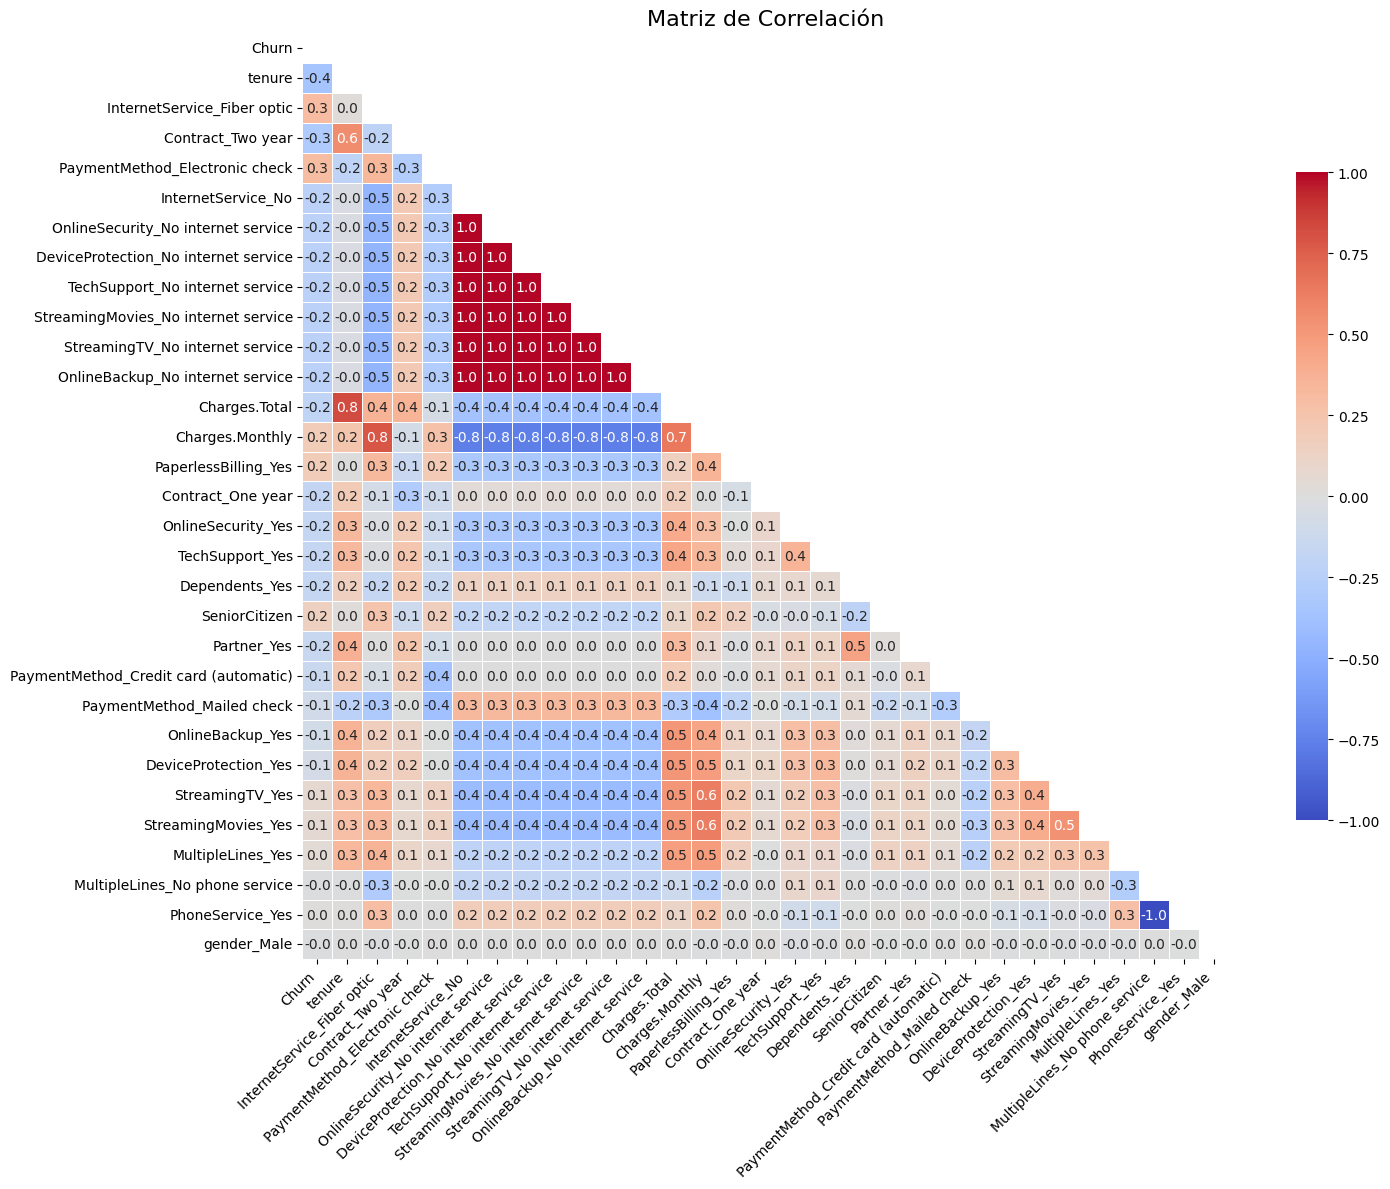

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular matriz de correlación solo con columnas numéricas
corr_matrix = df_encoded.corr(numeric_only=True)

# --- (Opcional) Ordenar las columnas por su correlación con Churn
corr_matrix = corr_matrix.loc[
    corr_matrix['Churn'].abs().sort_values(ascending=False).index,
    corr_matrix['Churn'].abs().sort_values(ascending=False).index
]

# --- (Opcional) Crear una máscara para mostrar solo la mitad inferior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# --- Crear el heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.1f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7}
)

plt.title('Matriz de Correlación', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Análisis Dirigido

### Tiempo de Contrato vs Cancelación

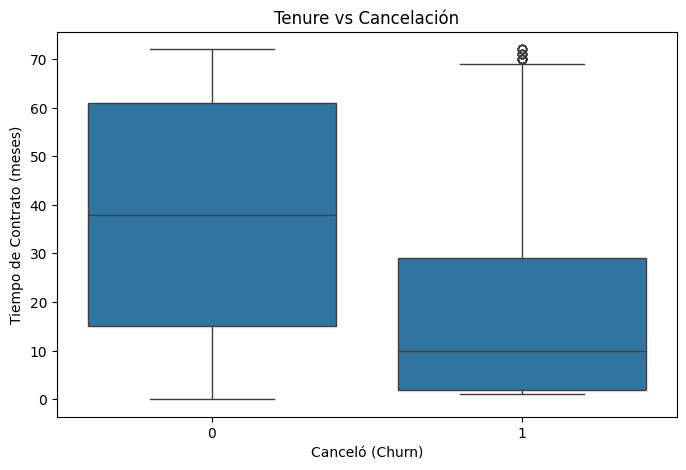

In [34]:
# creamos el gráfico tiempo de contrato vs cancelación
plt.figure(figsize=(8, 5))

# --- Crear un boxplot para ver cómo varía el tiempo de contrato según si el cliente canceló o no
sns.boxplot(x='Churn', y='tenure', data=df_encoded)

# --- Títulos y etiquetas
plt.title('Tenure vs Cancelación')
plt.xlabel('Canceló (Churn)')
plt.ylabel('Tiempo de Contrato (meses)')

plt.show()

###  Gasto Total vs Cancelación

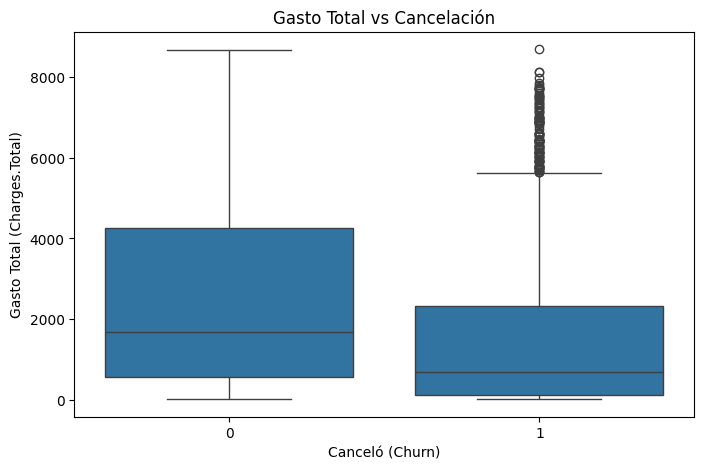

In [35]:
plt.figure(figsize=(8, 5))

# --- Creamos un boxplot para comparar el gasto total (Charges.Total) entre clientes que cancelaron y los que no
sns.boxplot(x='Churn', y='Charges.Total', data=df_encoded)

# --- Títulos y etiquetas
plt.title('Gasto Total vs Cancelación')
plt.xlabel('Canceló (Churn)')
plt.ylabel('Gasto Total (Charges.Total)')

plt.show()

### Tenure vs Gasto Total, coloreado por Churn

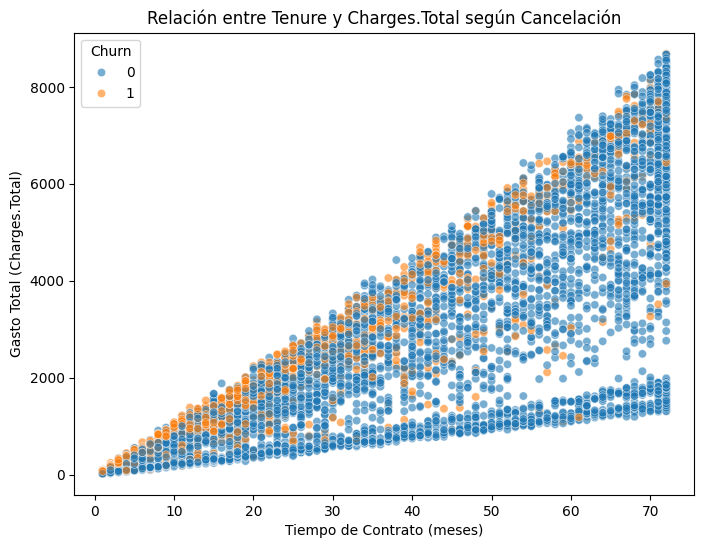

In [36]:
plt.figure(figsize=(8, 6))

# --- Creamos un scatterplot para ver relación entre tiempo de contrato y gasto total
# --- hue='Churn' colorea los puntos según si cancelaron o no
sns.scatterplot(data=df_encoded, x='tenure', y='Charges.Total', hue='Churn', alpha=0.6)

# --- Títulos y etiquetas
plt.title('Relación entre Tenure y Charges.Total según Cancelación')
plt.xlabel('Tiempo de Contrato (meses)')
plt.ylabel('Gasto Total (Charges.Total)')
plt.legend(title='Churn')

plt.show()

#Modelado Predictivo

## Separación de Datos

In [37]:
from sklearn.model_selection import train_test_split

# --- 1. Separar variables predictoras (X) y variable objetivo (y)
X = df_encoded.drop('Churn', axis=1)  # Todas las columnas excepto Churn
y = df_encoded['Churn']               # Columna objetivo

# --- 2. Dividir en entrenamiento (70%) y prueba (30%) con estratificación para mantener proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,               # 30% para prueba
    random_state=42,            # Reproducibilidad
    stratify=y                  # Mantener la misma proporción de clases
)

# --- 3. Mostrar tamaños de los conjuntos
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test:  {X_test.shape}")
print(f"Distribución en y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Distribución en y_test:\n{y_test.value_counts(normalize=True)}")

Tamaño de X_train: (4930, 30)
Tamaño de X_test:  (2113, 30)
Distribución en y_train:
Churn
0    0.734686
1    0.265314
Name: proportion, dtype: float64
Distribución en y_test:
Churn
0    0.734501
1    0.265499
Name: proportion, dtype: float64


##Creación de Modelos

In [39]:
#Modelo 1: Regresión Logística (con normalización)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --- Entrenar el modelo con los datos normalizados y balanceados
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_resampled)

# --- Predecir en el conjunto de prueba (también normalizado)
y_pred_logreg = logreg.predict(X_test_scaled)

# --- Evaluación del modelo
print("=== Regresión Logística ===")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_logreg))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_logreg, digits=3))

=== Regresión Logística ===
Matriz de Confusión:
[[1127  425]
 [ 112  449]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0      0.910     0.726     0.808      1552
           1      0.514     0.800     0.626       561

    accuracy                          0.746      2113
   macro avg      0.712     0.763     0.717      2113
weighted avg      0.805     0.746     0.759      2113



In [40]:
# 1. Imputar valores faltantes en X_test con el mismo imputador que en X_train
X_test_imputed = imputer.transform(X_test)

# 2. Reconstruir DataFrame para mantener columnas y nombres
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# 3. Escalar los datos imputados (no escales antes de imputar)
X_test_scaled = scaler.transform(X_test_imputed)

# Ahora puedes hacer predicciones sin error
y_pred_logreg = logreg.predict(X_test_scaled)

¿Por qué normalizamos los datos en modelos basados en distancia o optimización?

los modelos como Regresión Logística, K-Nearest Neighbors (KNN), Support Vector Machines (SVM) y Redes Neuronales usan algoritmos que:

*Calculan distancias entre puntos (KNN, SVM con kernel)

Si las variables tienen diferentes escalas, el algoritmo se sesga hacia las variables con valores más grandes, porque su rango domina las distancias o gradientes.

Las variables con valores pequeños pueden volverse irrelevantes para el modelo.

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Entrenamiento del modelo de Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [42]:
#modelo 2 Árbol de Decisión (sin normalización)

from sklearn.tree import DecisionTreeClassifier

# Entrenamos el modelo con los datos sin escalar pero imputados y balanceados
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_resampled, y_train_resampled)

# --- Predecir en el conjunto de prueba (también sin escalar)
y_pred_tree = tree.predict(X_test)

# --- Evaluación del modelo
print("=== Árbol de Decisión ===")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_tree))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_tree, digits=3))

=== Árbol de Decisión ===
Matriz de Confusión:
[[1236  316]
 [ 286  275]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0      0.812     0.796     0.804      1552
           1      0.465     0.490     0.477       561

    accuracy                          0.715      2113
   macro avg      0.639     0.643     0.641      2113
weighted avg      0.720     0.715     0.717      2113



## Evaluación de los modelos

In [43]:
#Importamos herramientas de evaluación

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

 Regresión Logística
Accuracy: 0.7458589682915286
Precision: 0.5137299771167048
Recall: 0.8003565062388592
F1-score: 0.6257839721254356

Reporte completo:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1552
           1       0.51      0.80      0.63       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113



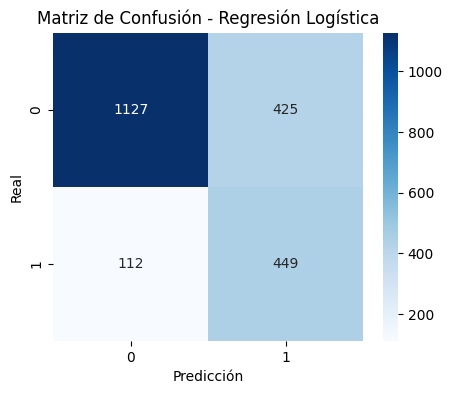

In [45]:
#Evaluar Modelo 1 — Regresión Logística

# --- Predicciones
y_pred_logreg = logreg.predict(X_test_scaled)

# --- Reporte de métricas
print(" Regresión Logística")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Precision:", precision_score(y_test, y_pred_logreg))
print("Recall:", recall_score(y_test, y_pred_logreg))
print("F1-score:", f1_score(y_test, y_pred_logreg))
print("\nReporte completo:\n", classification_report(y_test, y_pred_logreg))

# --- Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_logreg), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

Random Forest
Accuracy: 0.7780407004259347
Precision: 0.6
Recall: 0.4919786096256685
F1-score: 0.5406464250734574

Reporte completo:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1552
           1       0.60      0.49      0.54       561

    accuracy                           0.78      2113
   macro avg       0.71      0.69      0.70      2113
weighted avg       0.77      0.78      0.77      2113



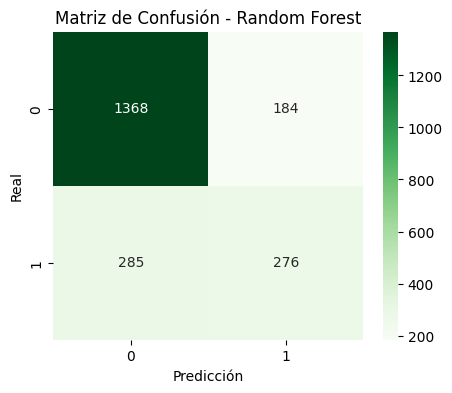

In [46]:
#Evaluar Modelo 2 — Arbol de desición

# --- Predicciones
y_pred_rf = rf.predict(X_test)  # No necesita escalado

# --- Reporte de métricas
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("\nReporte completo:\n", classification_report(y_test, y_pred_rf))

# --- Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

### Análisis critico de los modelos

Regresión Logística (con normalización)
Métrica	Valor
Accuracy	0.746
Precision	0.514
Recall	0.800
F1-score	0.626

Puntos buenos:

Muy buen recall para la clase 1 (cancelaciones): detecta el 80% de quienes cancelan.

Es útil si nuestro objetivo es no dejar pasar clientes que podrían cancelar, aunque puede haber errores a veces.

Puntos malos:

Baja precisión para la clase 1: muchos falsos positivos (predice cancelación cuando no la hay).

Esto puede llevanos a acciones innecesarias sobre clientes que en realidad no iban a cancelar.

Modelo 2: Random Forest (sin normalización)
Métrica	Valor
Accuracy	0.778
Precision	0.600
Recall	0.492
F1-score	0.541

Puntos buenos :

Mayor precisión que el modelo 1 (menos falsos positivos).

Mayor accuracy general del modelo.

Equilibrado en rendimiento general.

Puntos malos:

Menor recall: solo detecta el 49% de los clientes que cancelan.

Puede dejar pasar casi la mitad de las cancelaciones, lo cual es riesgoso si eso es lo que queremos evitar.

##Comparación entre ambos modelos

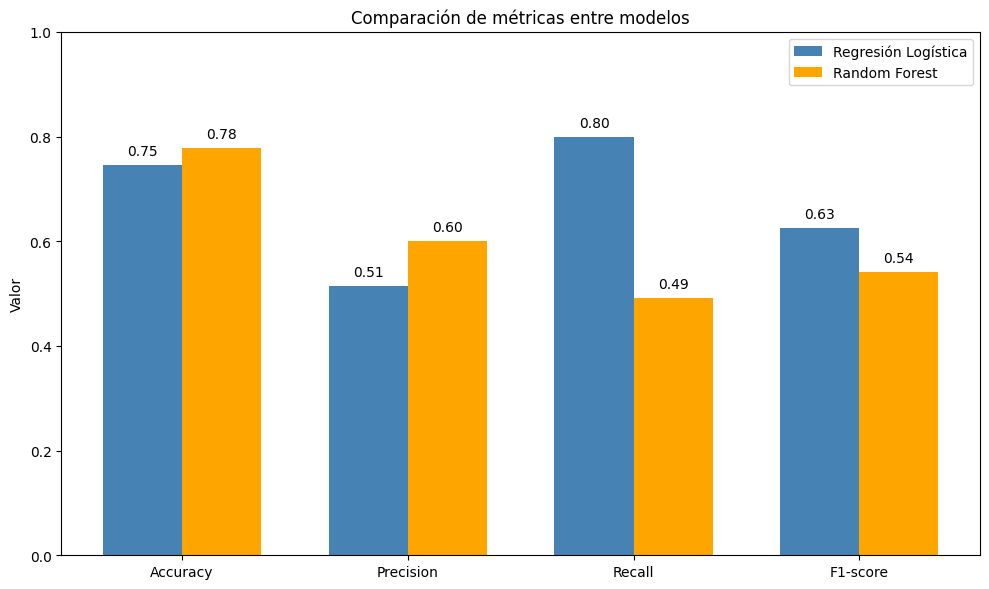

In [47]:
# Métricas de los modelos
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-score']
logistic_values = [0.746, 0.514, 0.800, 0.626]
rf_values = [0.778, 0.600, 0.492, 0.541]

x = np.arange(len(metricas))  # etiquetas de los ejes
width = 0.35  # ancho de las barras

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, logistic_values, width, label='Regresión Logística', color='steelblue')
bars2 = ax.bar(x + width/2, rf_values, width, label='Random Forest', color='orange')

# Etiquetas y título
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre modelos')
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.set_ylim(0, 1)
ax.legend()

# Agregar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # desplazamiento vertical
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

##Overfitting o Underfitting
Ninguno de los dos modelos muestra overfitting evidente (ambos rinden de forma razonable en test).

Regresión Logística podría estar más ajustada al patrón de cancelaciones, pero eso no necesariamente indica overfitting — puede ser una característica deseada si se gestiona bien el costo de los falsos positivos.

# Interpretación y conclusiones

## Análisis de la Importancia de las Variables

Modelo de regresión logística

In [48]:
coef = logreg.coef_[0]  # Extrae los coeficientes del modelo
variables = X_train.columns

coef_df = pd.DataFrame({
    'Variable': variables,
    'Coeficiente': coef
})
coef_df['Impacto'] = coef_df['Coeficiente'].apply(lambda x: 'Positivo' if x > 0 else 'Negativo')
coef_df = coef_df.sort_values(by='Coeficiente', key=np.abs, ascending=False)

print(coef_df.head(10))

                          Variable  Coeficiente   Impacto
1                           tenure    -1.560883  Negativo
3                    Charges.Total     0.838559  Positivo
2                  Charges.Monthly    -0.760691  Negativo
10     InternetService_Fiber optic     0.646281  Positivo
25               Contract_Two year    -0.564434  Negativo
24               Contract_One year    -0.297977  Negativo
21                 StreamingTV_Yes     0.230808  Positivo
28  PaymentMethod_Electronic check     0.219895  Positivo
23             StreamingMovies_Yes     0.208935  Positivo
26            PaperlessBilling_Yes     0.208417  Positivo


En el modelo de regresión logística, la variable con mayor peso negativo fue tenure, indicando que los clientes con mayor antigüedad tienen menor probabilidad de cancelar. Por otro lado, el gasto total y el uso de servicios como Internet por fibra óptica y métodos de pago como electronic check se relacionan positivamente con la cancelación.
Además, los contratos a uno y dos años reducen significativamente la probabilidad de churn, destacando la importancia de fomentar compromisos a largo plazo para la retención. Variables asociadas a servicios de streaming y facturación digital muestran también un ligero aumento en el riesgo de cancelación.

Modelo 2 Arbol de decisión

In [49]:
importancia = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': tree.feature_importances_
}).sort_values(by='Importancia', ascending=False)

print(importancia.head(10))

                          Variable  Importancia
28  PaymentMethod_Electronic check     0.269560
1                           tenure     0.174852
3                    Charges.Total     0.123747
2                  Charges.Monthly     0.116404
10     InternetService_Fiber optic     0.056226
26            PaperlessBilling_Yes     0.029705
4                      gender_Male     0.028658
24               Contract_One year     0.025647
9                MultipleLines_Yes     0.017597
0                    SeniorCitizen     0.015481


En el modelo de árbol de decisión, la variable más importante para predecir la cancelación fue el método de pago electrónico (Electronic check), seguida por la antigüedad del cliente (tenure) y el gasto total.
Además, variables como el cargo mensual, el tipo de servicio de internet, y factores demográficos como género y condición de adulto mayor también contribuyeron, aunque con menor peso.
En conjunto, el árbol resalta la heterogeneidad de factores que influyen en la cancelación, incluyendo aspectos demográficos y métodos de pago.

# Conclusión

## 1. Resumen del desempeño de los modelos
Se evaluaron dos modelos predictivos para anticipar la cancelación (churn) de clientes:

Regresión Logística (con normalización):

Accuracy: 74.6%

Recall (cancelación): 80.0% (muy buena capacidad para detectar clientes que cancelan)

Precision (cancelación): 51.4%

F1-score (cancelación): 62.6%

Árbol de Decisión (sin normalización):

Accuracy: 77.8%

Recall (cancelación): 49.2% (menor detección de churn comparado con regresión logística)

Precision (cancelación): 60.0% (menos falsos positivos que regresión)

F1-score (cancelación): 54.1%

Interpretación: La regresión logística ofrece un mejor recall, lo que la hace más adecuada para identificar la mayoría de los clientes que probablemente cancelen, aunque con más falsos positivos. Por otro lado, el árbol de decisión tiene mayor precisión y accuracy, pero detecta menos churners.

## 2. Variables que más influyen en la cancelación
Modelo Regresión Logística
tenure: Antigüedad del cliente. A mayor tiempo contratado, menor probabilidad de cancelar.

Charges.Total: Clientes con mayor gasto total tienen más riesgo de cancelar.

Charges.Monthly: Contrariamente, cargos mensuales altos reducen el churn, posiblemente asociado a contratos largos o clientes premium.

InternetService_Fiber optic: Usuarios con fibra óptica tienen mayor riesgo de cancelación.

Contract_Two year / One year: Contratos a largo plazo reducen la probabilidad de churn.

PaymentMethod_Electronic check: Método de pago electrónico ligado a mayor cancelación.

Modelo Árbol de Decisión
PaymentMethod_Electronic check: Variable más relevante; indica una clara asociación entre este método de pago y cancelación.

tenure, Charges.Total, Charges.Monthly: Variables importantes que coinciden con regresión logística.

InternetService_Fiber optic: También destacada como factor de riesgo.

Facturación sin papel, género, múltiples líneas y ser adulto mayor también aportan, aunque con menor peso.

## 3. Recomendaciones estratégicas para retención
Basándonos en los resultados, proponemos las siguientes estrategias para minimizar la cancelación de clientes:

Fomentar contratos a largo plazo: Los contratos de uno y dos años se asocian con menor churn. Se pueden diseñar campañas o incentivos para que los clientes actuales y nuevos opten por compromisos más largos.

Revisar y mejorar la experiencia para usuarios con fibra óptica: Dado que esta variable se asocia con mayor cancelación, es vital entender sus problemas específicos (calidad del servicio, soporte técnico, precios) y trabajar en mejorar la satisfacción.

Analizar el método de pago electrónico (Electronic check): Como está fuertemente ligado a churn, revisar posibles inconvenientes (fallos en cobros, problemas de confianza o usabilidad) y ofrecer alternativas o mejoras en la experiencia de pago puede reducir cancelaciones.

Segmentación basada en antigüedad (tenure): Clientes nuevos o con baja antigüedad son más propensos a cancelar; campañas de bienvenida, soporte personalizado y ofertas especiales pueden aumentar su fidelidad.

Atención a clientes con altos cargos totales: Aunque gastan más, tienen riesgo de churn, por lo que es recomendable monitorear su satisfacción y ofrecer valor añadido para mantenerlos.

## 4. Elección del modelo para despliegue
Si la prioridad es capturar la mayor cantidad de clientes que van a cancelar (minimizar falsos negativos), se recomienda el modelo de regresión logística por su mayor recall.

Si se desea reducir las falsas alarmas y tener predicciones más precisas, el árbol de decisión es más adecuado.